# Onsale Model Classification

#### Author: Andrew Pierson

## Purpose

The purpose of this notebook is to determine how to preprocess data in order to retain as much information as possible and to determine which algorithm is the most effective at predicting. The dataset that is being used is a .csv containing historical sales data for over 125,000 events on the secondary ticket market. An algorithm will be chosen based upon its ability to predict whether or not an event should be purchased in order to make a ceterain amount of profit. The accuracy of the model will be a determining factor when determining which model is best and models with lower Type 1 errors will be chosen in the situation that there is a close accuracy. Type 1 errors, or false positives, will be important to minimize because they will result in losses, whereas false negatives will only result in opportunity loss and not actual financial losses. 

## Methodology/Agenda

1) Exploratory Data Analysis

2) Classification Models

    a) Model Tuning
    
    b) Model Performance

3) Conclusion

4) Final Model Spark Implementation

## Exploratory Data Analysis (EDA) and Preprocessing

Determine the current working directory in order to select files from the correct storage source.  Change the working directory to the correct file location and import csv information with historical information about tickets. The ticket data will have information that was selected from a SQL query on a local database.

In [1]:
#Determine working directory
import os
os.getcwd()

'C:\\Users\\apierson\\Desktop\\Predictive Modeling\\Models'

In [2]:
#Change working directory to current date
os.chdir('C:\\Users\\apierson\\Desktop\\Predictive Modeling\\Raw Data and Output')

In [3]:
#Import in packages for EDA
import pandas as pd
#Read in and define Historical dataset
Historical = pd.read_csv('HistoricalData06122018.csv')

In [4]:
#Load package that will remove deprication warnings
import warnings
warnings.filterwarnings("ignore")

### EDA

Beginning exploratory data analysis (EDA) by looking at the beginning five rows of data shows the schema of the dataset. This reveals that six of the columns are categorical and three are continuous numerical. Since we will be using profit as the predictor of whether or not to buy we will need to change this to a categorical dimension at some point.

In [5]:
#Taking a quick glance at the top 5 rows to get a feel for the data
Historical.head()

Profit             Event_Name Event_Category          Venue_Name  \
0   27.00  Philadelphia Phillies   Pro Baseball  Citizens Bank Park   
1    9.00  Philadelphia Phillies   Pro Baseball  Citizens Bank Park   
2  748.38  Philadelphia Phillies   Pro Baseball  Citizens Bank Park   
3 -623.63  Philadelphia Phillies   Pro Baseball  Citizens Bank Park   
4   13.87  Philadelphia Phillies   Pro Baseball  Citizens Bank Park   

   Venue_Capacity    Event_City  Event_Region Event_Date  Days_On_Market  
0         43647.0  Philadelphia  Pennsylvania      March            38.0  
1         43647.0  Philadelphia  Pennsylvania      March            39.0  
2         43647.0  Philadelphia  Pennsylvania      April            69.0  
3         43647.0  Philadelphia  Pennsylvania      April           181.0  
4         43647.0  Philadelphia  Pennsylvania      April           182.0

There might be null values in the continuous, numerical data. Printing summary statistics will be useful when deciding to drop null values or replace them with an estimate.

In [6]:
#Exploring the summary statistics of the numerical dimensions of the Historical dataset
Historical.describe()

Profit  Venue_Capacity  Days_On_Market
count  140944.000000   120647.000000   140894.000000
mean      348.761642    22830.719678      131.251217
std      2021.441552    21107.069460       79.805403
min    -50220.660000        1.000000     -337.000000
25%       -67.860000     5000.000000       74.000000
50%        79.340000    18797.000000      120.000000
75%       390.282500    37400.000000      180.000000
max    211795.120000   257235.000000     1517.000000

### Data Properties

Printing info about the datatypes will reinforce knowledge on the data and what transformations might need to occur later. Looking at this compared to the amount of null values per column is a good way to diagnose problems that might occur when cleaning data.

In [7]:
#Determine the attributes of each dimension in the Adult dataset
Historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140944 entries, 0 to 140943
Data columns (total 9 columns):
Profit            140944 non-null float64
Event_Name        140944 non-null object
Event_Category    138808 non-null object
Venue_Name        140895 non-null object
Venue_Capacity    120647 non-null float64
Event_City        140389 non-null object
Event_Region      140389 non-null object
Event_Date        140894 non-null object
Days_On_Market    140894 non-null float64
dtypes: float64(3), object(6)
memory usage: 9.7+ MB


After running a null count command on the Historical dataset it is apparent that the largest source of corrupt data is the Venue_Capacity column. Luckily, this column is a continuous, numerica value and therefore we can estimate it easily. The same can be done for the Days_On_Market column due to its datatype. On the other hand, the Event_Category cannot be estimated and neither can the Event_Region, Event_City, or Venue_Name.

In [8]:
#Use the is.null command to produce a count of NaN or missing values
null_counts = Historical.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending = False)

Venue_Capacity    20297
Event_Category     2136
Event_Region        555
Event_City          555
Days_On_Market       50
Event_Date           50
Venue_Name           49
dtype: int64

### Distributions

Looking at the distributions for the Event_Catgeory we notice that there are almost twice as many for professional baseball events than any other category of event. We can also see that there are a ton of events that happen in California and New York. These are likely popular destinations for performers and event managers to schedule locations, they also have a large number of people living in these spaces and therefore have a better possibility to make more money on an event.

In [9]:
#Distribution of Event_Category using bar plot to compare 
Historical['Event_Category'].value_counts().plot(kind='bar')

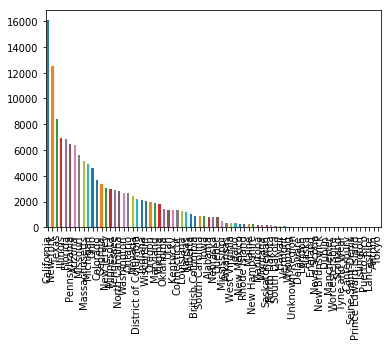

In [10]:
#Distribution of workclass using bar plot to compare 
Historical['Event_Region'].value_counts().plot(kind='bar')

### Relace Missing Data

The next step is to replace the large majority of missing values in the Venue_Capacity and Days_On_Market columns with the median value of the non-null portion of the dataset. The rest of the rows that contain null values will be dropped, the following null value count shows there are now zero missing values from the Historical dataset.

In [11]:
#Fill the null values for Days on Market with the median value
Historical['Days_On_Market'] = Historical['Days_On_Market'].fillna(120)
#Fill the null values for Venue Capacity with the mean value
Historical['Venue_Capacity'] = Historical['Venue_Capacity'].fillna(22831)

In [12]:
#Since we cannot fill the null values of the categorical dimensions with an estimate we are going to drop them
Historical = Historical.dropna()

In [13]:
#To ensure that our dataset is free of null values generate another count of NaN, finding zero na's we can proceed with exploratory data analysis (EDA)
null_counts = Historical.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending = False)

Series([], dtype: int64)

### Create Target Variable, Test/Train Sets, and Normalize Dataset

Normalizing the data makes it easier to compare to other numerical variables that have a different unit of measure. It also puts the numerical data on a much smaller scale, from zero to one. 

In [14]:
#Normalize the numerical dimensions to make them easier to compare
Historical['Days_On_Market'] = (Historical['Days_On_Market'] - Historical['Days_On_Market'].min())/(Historical['Days_On_Market'].max()-Historical['Days_On_Market'].min())
Historical['Venue_Capacity'] = (Historical['Venue_Capacity'] - Historical['Venue_Capacity'].min())/(Historical['Venue_Capacity'].max()-Historical['Venue_Capacity'].min())
#Historical['Profit'] = (Historical['Profit'] - Historical['Profit'].min())/(Historical['Profit'].max()-Historical['Profit'].min())

This portion of code transforms the Profit column, which gives a numerical value in dollars based on the amount of profit made from the show. We find that the 70th percentile of the profit is about 100 dollars and therefore decide to base our decision on buying shows whether they make a profit of greater than or less than one-hundred dollars. If the show will make 100 dollars or more we want to buy it, therefore it is represented with the value of 1. If it does not meet these conditions it is assigned a value of 0. After doing this we will drop the profit column because the 'Buy' column is a mask of the profit. 

In [15]:
#Load package numpy to categorize Profit variable into buy or not buy (1 or 0) categories
import numpy as np
Historical['Buy'] = np.where(Historical['Profit'] < 390.28, '0', '1') 

In [16]:
#The Profit dimension of the Historical dataset has been categorized and there is no further use for it so we drop it
Historical = Historical.drop('Profit', axis=1)

The Event_Name, names of the show are not a direct factor and dummying them would create an extremely sparse matrix, therefore the column is dropped along with the Venue_Name column. The rest of the dimensions are dummied and we find that we are left with 154 columns and a dataset that is over 125,000 rows.

In [17]:
#Change all categorical dimensions into dummy variables and drop columns that are not dummied
#Event_Name dummies
#Historical_dummies = pd.get_dummies(Historical['Event_Name'], dummy_na=True)
#Historical = pd.concat([Historical, Historical_dummies], axis=1)
Historical = Historical.drop('Event_Name', axis = 1)
#Event_Date dummies
Historical_dummies = pd.get_dummies(Historical['Event_Date'], dummy_na=True)
Historical = pd.concat([Historical, Historical_dummies], axis=1)
Historical = Historical.drop('Event_Date', axis=1)
#Event_Category dummies
Historical_dummies = pd.get_dummies(Historical['Event_Category'], dummy_na=True)
Historical = pd.concat([Historical, Historical_dummies], axis=1)
Historical = Historical.drop('Event_Category', axis=1)
#Venue_Name dummies
#Historical_dummies = pd.get_dummies(Historical['Venue_Name'], dummy_na=True)
#Historical = pd.concat([Historical, Historical_dummies], axis=1)
Historical = Historical.drop('Venue_Name', axis=1)
#Event_City dummies
#Historical_dummies = pd.get_dummies(Historical['Event_City'], dummy_na=True)
#Historical = pd.concat([Historical, Historical_dummies], axis=1)
Historical = Historical.drop('Event_City', axis=1)
#Event_Region dummies
Historical_dummies = pd.get_dummies(Historical['Event_Region'], dummy_na=True)
Historical = pd.concat([Historical, Historical_dummies], axis=1)
Historical = Historical.drop('Event_Region', axis=1)

In [18]:
#Take a look at the dataset that is left after dropping dimensions and dummying variables
Historical.head()

Venue_Capacity  Days_On_Market Buy  April  August  December  February  \
0        0.169674        0.202265   0      0       0         0         0   
1        0.169674        0.202805   0      0       0         0         0   
2        0.169674        0.218986   1      1       0         0         0   
3        0.169674        0.279396   0      1       0         0         0   
4        0.169674        0.279935   0      1       0         0         0   

   January  July  June ...   Unknown Region  Utah  Vermont  Virginia  \
0        0     0     0 ...                0     0        0         0   
1        0     0     0 ...                0     0        0         0   
2        0     0     0 ...                0     0        0         0   
3        0     0     0 ...                0     0        0         0   
4        0     0     0 ...                0     0        0         0   

   Washington  West Virginia  Wisconsin  Worcestershire  Wyoming  NaN  
0           0              0          0               0        0    0  
1           0              0          0               0        0    0  
2           0              0          0               0        0    0  
3           0              0          0               0        0    0  
4           0              0          0               0        0    0  

[5 rows x 154 columns]

Partition the dataset in order to have testing and training portions of data, 70 percent will be used to train and 30 percent will be used to test. Here is where we specify our target variable as Y, whether we will buy or not buy. 

In [19]:
#Create samples of the Historical dataset using a 70%-30% split on train-test
from sklearn.model_selection import train_test_split
Historical_train, Historical_test = train_test_split(Historical, test_size=0.3)
#Create the variable X to use as the training data and Y as the target values
X = Historical_train
Y = Historical_train['Buy']

## K Nearest Neighbors Models

### K Nearest Neighbors with default parameters

The KNN model with default parameters appears to have a very strong prediction capability, although it has over 3 times as many false positives as the number of false negatives. The error on this model is very low and the majority of it comes from the type 1 error which might be case for us to use a different model type. Tuning this will allow us to determine if we can get lift in the form of type 1 error.

In [20]:
#Load package to run a K Nearest Neighbors (KNN) model 
from sklearn.neighbors import KNeighborsClassifier
#Construct and test a KNN model with default parameters
knn = KNeighborsClassifier()
knn_fit = knn.fit(X, Y)
knn_pred = knn_fit.predict(Historical_test)
print(knn_pred)

['0' '0' '0' ... '1' '0' '0']


#### Performance

In [21]:
#Load package to determine what the accuracy of the model is
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
knn_accuracy = accuracy_score(Historical_test['Buy'], knn_pred)
print('Accuracy:', knn_accuracy)
#Show confusion matrix from KNN classification model
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], knn_pred))
#The Mean Squared Error (MSE) of the KNN CV model
knn_mse = mean_squared_error(Historical_test['Buy'], knn_pred)
print('Mean Squared Error:', knn_mse)

Accuracy: 0.9518690800414548
Confusion Matrix:
[[30599   414]
 [ 1583  8895]]
Mean Squared Error: 0.048130919958545224


### K Nearest Neighbors GridSearchCV for n_neighbors

This model has the same score as the first model, this is obvious because the default number of n_neighbors is 3. It could be assumed that we would get about the same amount of type 1 error but we will test anyway to make sure that this prediction is correct. The result is the same as the first model and thus we will tune a different parameter of the knn model.

In [65]:
#Tune KNN number of neighbors parameter by methodically building and evaluating specified combinations of grid search parameters
from sklearn.model_selection import GridSearchCV
neighbors = np.array([2, 3, 4, 5])
#Run grid search for k 2:5, the most practical values
knn_grid = GridSearchCV(estimator=knn, param_grid=dict(n_neighbors=neighbors))
knn_grid.fit(Historical_train, Historical_train['Buy'])
#The results of the grid search indicate that a k value of  nearest neighbors will result in the best scoring model
print('Best Model Score:', knn_grid.best_score_)
print('Best n_neighbors Estimator:', knn_grid.best_estimator_.n_neighbors)

Best Model Score: 0.946979165590687
Best n_neighbors Estimator: 3


#### n_neighbors = 3

In [66]:
#Evaluate K Nearest Neighbors (KNN) model with number of k-neighbors associated with best grid search score 
knn5 = KNeighborsClassifier(n_neighbors = 3)
knn5_fit = knn5.fit(X, Y)
knn5_pred = knn5_fit.predict(Historical_test)
#Load scikit-learn package with tool for scoring accuracy
from sklearn.metrics import accuracy_score,  mean_squared_error
#The accuracy of the KNN5 model
knn5_accuracy = accuracy_score(Historical_test['Buy'], knn5_pred)
print('Accuracy:', knn5_accuracy)
#Show confusion matrix from KNN classification model
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], knn5_pred))
#The Mean Squared Error (MSE) of the KNN5 model
knn5_mse = mean_squared_error(Historical_test['Buy'], knn5_pred)
print('Mean Squared Error:', knn5_mse)

Accuracy: 0.9518690800414548
Confusion Matrix:
[[30599   414]
 [ 1583  8895]]
Mean Squared Error: 0.048130919958545224


### K Nearest Neighbors GridSearchCV for leaf_size

Changing the leaf size resulted in a lower model score than the previous 3 nearest neighbor models. The result of this

In [67]:
#Tune KNN number of neighbors parameter by randomly building and evaluating each specified combination of parameters using randomized grid search
#Load randomized grid search package from scitkit-learn
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
sizes = np.array([10, 25, 50, 75])
#Run grid search for k 2:5, the most practical values
knn_rand_grid = GridSearchCV(estimator=knn, param_grid = dict(leaf_size = sizes))
knn_rand_grid_fit = knn_rand_grid.fit(X, Y)
#The results of the grid search indicate that a k value of 5 nearest neighbors will result in the best scoring model
print('Best Model Score:', knn_rand_grid_fit.best_score_)
print('Best leaf_size Estimator:', knn_rand_grid_fit.best_estimator_.leaf_size)

Best Model Score: 0.9425994979909308
Best leaf_size Estimator: 10


#### leaf_size = 10

In [68]:
#Evaluate K Nearest Neighbors (KNN) model with the mean accuracy of 5 cross validation (CV) scores
#The accuracy of the KNN CV model
from sklearn.model_selection import cross_val_score
knn_ls_accuracy = cross_val_score(knn, X, Y, cv=5, scoring='accuracy')
print('Accuracy:', knn_ls_accuracy)
#Show confusion matrix from KNN classification model
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], knn5_pred))
#The Mean Squared Error (MSE) of the KNN CV model
knn_cv_mse = cross_val_score(knn, X, Y, cv=5, scoring='neg_mean_squared_error')
print('Mean Squared Error:', knn_cv_mse.mean())

Accuracy: [0.94515313 0.94437558 0.94540853 0.94737114 0.9491788 ]
Confusion Matrix:
[[30599   414]
 [ 1583  8895]]
Mean Squared Error: -0.0537025633005588


### K Nearest Neighbors Cross Validation

In [69]:
#Tune KNN parameters by cross validation
#Load scikit-learn package tool for cross validation
from sklearn.cross_validation import cross_val_score
#Cross validation of the k nearest neighbors model
cross_val_score(knn, X, Y, cv = 5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


array([0.94515313, 0.94437558, 0.94540853, 0.94737114, 0.9491788 ])

#### cv = 5

In [70]:
#Evaluate K Nearest Neighbors (KNN) model with the mean accuracy of 5 cross validation (CV) scores
#The accuracy of the KNN CV model
knn_cv_accuracy = cross_val_score(knn, X, Y, cv=5, scoring='accuracy')
print('Accuracy:', knn_cv_accuracy.mean())
#Show confusion matrix from KNN classification model
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], knn5_pred))
#The Mean Squared Error (MSE) of the KNN CV model
knn_cv_mse = cross_val_score(knn, X, Y, cv=5, scoring='neg_mean_squared_error')
print("Negative Mean Squared Error:", knn_cv_mse.mean())

Accuracy: 0.9462974366994412
Confusion Matrix:
[[30599   414]
 [ 1583  8895]]
Negative Mean Squared Error: -0.0537025633005588


## Decision Tree Models

### Decision Tree with default parameters

In [24]:
#Load package to construct decision tree model
from sklearn import tree
#Construct a basic decision tree and show the classification, switch criterion and max_depth parameters from their default values
dt = tree.DecisionTreeClassifier()
dt_fit = dt.fit(X, Y)
dt_pred = dt_fit.predict(Historical_test)
print(dt_pred)

['1' '0' '0' ... '1' '0' '0']


#### Performance

In [25]:
#Evaluate Decision Tree model with maximum depth of 6
#Load scikit-learn package with tool for scoring accuracy
from sklearn.metrics import accuracy_score
#The accuracy of the decision tree model
dt_accuracy = accuracy_score(Historical_test['Buy'], dt_pred)
print(dt_accuracy)
#Show confusion matrix from DT classification model
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], dt_pred))
#The Mean Squared Error (MSE) of the KNN CV model
dt_mse = mean_squared_error(Historical_test['Buy'], dt_pred)
print('Mean Squared Error:', dt_mse)

1.0
Confusion Matrix:
[[31013     0]
 [    0 10478]]
Mean Squared Error: 0.0


### Decision Tree GridSearchCV for max_depth

In [27]:
#Tune Decision Tree max depth parameter by methodically building and evaluating each specified combination of parameters using grid search
from sklearn.model_selection import GridSearchCV
depths = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10])
#Run grid search to find the best max depth of the decision tree
dt_grid = GridSearchCV(estimator=dt, param_grid=dict(max_depth = depths))
dt_grid_fit = dt_grid.fit(Historical_train, Historical_train['Buy'])
#The results of the grid search indicate that a k value of 5 nearest neighbors will result in the best scoring model
print('Best Model Score:', dt_grid_fit.best_score_)
print('Best max_depth Estimator:', dt_grid_fit.best_estimator_.max_depth)

Best Model Score: 1.0
Best max_depth Estimator: 2


#### max_depth = 2

In [29]:
#Evaluate Decision Tree model max depth number associated with best grid search score 
dt2 = tree.DecisionTreeClassifier(max_depth = 2)
dt2_fit = dt2.fit(X, Y)
dt2_pred = dt2_fit.predict(Historical_test)
#Load scikit-learn package with tool for scoring accuracy
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
#The accuracy of the max depth = 2 decision tree model
dt2_accuracy = accuracy_score(Historical_test['Buy'], dt2_pred)
print('Accuracy:', dt2_accuracy)
#Show confusion matrix from DT classification model
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], dt2_pred))
#The Mean Squared Error (MSE) of the max depth = 2 decision tree model
dt2_mse = mean_squared_error(Historical_test['Buy'], dt2_pred)
print('Mean Squared Error:', dt2_mse)

Accuracy: 1.0
Confusion Matrix:
[[31013     0]
 [    0 10478]]
Mean Squared Error: 0.0


### Decision Tree GridSearchCV for max_features

In [30]:
#Tune Decision Tree max features parameter by methodically building and evaluating each specified combination of parameters using grid search
#Specify that the number of features to be tested be evenly distribute in a list from 1 to 50
param_grid = {'max_features':np.arange(1,50)}
dt_mfx_cv = GridSearchCV(dt, param_grid, cv = 5)
dt_mfx_cv_fit = dt_mfx_cv.fit(X, Y)
print('Best Model Score:', dt_mfx_cv_fit.best_params_)
print('Best max_features Estimator:', dt_mfx_cv_fit.best_score_)

Best Model Score: {'max_features': 39}
Best max_features Estimator: 0.9999483529764179


#### max_features = 39

In [32]:
#Evaluate Decision Tree model max features number associated with best grid search score 
dt_mfx_cv = tree.DecisionTreeClassifier(max_features = 39)
dt_mfx_cv_fit = dt_mfx_cv.fit(X, Y)
dt_mfx_cv_pred = dt_mfx_cv_fit.predict(Historical_test)
#Load scikit-learn package with tool for scoring accuracy
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
#The accuracy of the max features = 40 decision tree model
dt_mfx_cv_accuracy = accuracy_score(Historical_test['Buy'], dt_mfx_cv_pred)
print('Accuracy:', dt_mfx_cv_accuracy)
#Show confusion matrix from DT classification model
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], dt_mfx_cv_pred))
#The Mean Squared Error (MSE) of the max features = 40 decision tree model
dt_mfx_cv_mse = mean_squared_error(Historical_test['Buy'], dt_mfx_cv_pred)
print('Mean Squared Error:', dt_mfx_cv_mse)

Accuracy: 0.999638475814032
Confusion Matrix:
[[31007     6]
 [    9 10469]]
Mean Squared Error: 0.00036152418596804126


### Decision Tree GridSearchCV for min_samples_split

In [33]:
#Tune Decision Tree max features parameter by methodically building and evaluating each specified combination of parameters using grid search
#Specify that the number of features to be tested be evenly distribute in a list from 1 to 50
param_grid = {'min_samples_split':np.arange(2,50)}
dt_mss_cv = GridSearchCV(dt, param_grid, cv = 5)
dt_mss_cv_fit = dt_mss_cv.fit(X, Y)
print('Best Model Score:', dt_mss_cv_fit.best_params_)
print('Best min_samples_split Estimator:', dt_mss_cv_fit.best_score_)

Best Model Score: {'min_samples_split': 2}
Best min_samples_split Estimator: 1.0


#### min_samples_split = 

In [34]:
#Evaluate Decision Tree model max depth number associated with best grid search score 
dt_mss_cv = tree.DecisionTreeClassifier(min_samples_split = 2)
dt_mss_cv_fit = dt_mss_cv.fit(X, Y)
dt_mss_cv_pred = dt_mss_cv_fit.predict(Historical_test)
#Load scikit-learn package with tool for scoring accuracy
from sklearn.metrics import accuracy_score, mean_squared_error
#The accuracy of the max depth = 2 decision tree model
dt_mss_cv_accuracy = accuracy_score(Historical_test['Buy'], dt_mss_cv_pred)
print('Accuracy:', dt_mss_cv_accuracy)
#Show confusion matrix from DT classification model
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], dt_mss_cv_pred))
#The Mean Squared Error (MSE) of the max depth = 2 decision tree model
dt_mss_cv_mse = mean_squared_error(Historical_test['Buy'], dt_mss_cv_pred)
print('Mean Squared Error', dt_mss_cv_mse)

Accuracy: 1.0
Confusion Matrix:
[[31013     0]
 [    0 10478]]
Mean Squared Error 0.0


## Random Forest Models

### Random Forest with default parameters

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
rf = RandomForestClassifier()
rf_fit = rf.fit(X, Y)
rf_pred = rf_fit.predict(Historical_test)
print(rf_pred)

['1' '0' '0' ... '1' '0' '0']


#### Performance

In [36]:
#Evaluate Decision Tree model with maximum depth of 6
#Load scikit-learn package with tool for scoring accuracy
from sklearn.metrics import accuracy_score
#The accuracy of the decision tree model
rf_accuracy = accuracy_score(Historical_test['Buy'], rf_pred)
print('Accuracy:', rf_accuracy)
#Show confusion matrix from RF classification model
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], rf_pred))
#The Mean Squared Error (MSE) of the max depth = 2 decision tree model
rf_mse = mean_squared_error(Historical_test['Buy'], rf_pred)
print('Mean Squared Error:', rf_mse)

Accuracy: 1.0
Confusion Matrix:
[[31013     0]
 [    0 10478]]
Mean Squared Error: 0.0


### Random Forest GridsearchCV for max_depth

In [37]:
#Tune Random Forest max depth parameter by methodically building and evaluating each specified combination of parameters using grid search
from sklearn.model_selection import GridSearchCV
depths = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10])
#Run grid search to find the best max depth of the decision tree
rf_grid = GridSearchCV(estimator=rf, param_grid=dict(max_depth = depths))
rf_grid_fit = rf_grid.fit(Historical_train, Historical_train['Buy'])
#The results of the grid search result in the best scoring model
print('Best Model Score:', rf_grid_fit.best_score_)
print('Best max_depth Estimator:', rf_grid_fit.best_estimator_.max_depth)

Best Model Score: 0.9974899546539133
Best max_depth Estimator: 9


#### max_depth = 9

In [38]:
#Evaluate Random Forest model max depth number associated with best grid search score 
rf_md = RandomForestClassifier(max_depth = 9)
rf_md.fit(X, Y)
rf_md_pred = rf_md.predict(Historical_test)
#Load scikit-learn package with tool for scoring accuracy
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
#The accuracy of the max depth = 2 decision tree model
rf_md_accuracy = accuracy_score(Historical_test['Buy'], rf_md_pred)
print('Accuracy:', rf_md_accuracy)
#Show confusion matrix from RF classification model
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], rf_md_pred))
#The Mean Squared Error (MSE) of the max depth = 2 decision tree model
rf_md_mse = mean_squared_error(Historical_test['Buy'], rf_md_pred)
print('Mean Squared Error:', rf_md_mse)

Accuracy: 1.0
Confusion Matrix:
[[31013     0]
 [    0 10478]]
Mean Squared Error: 0.0


### Random Forest GridSearchCV for min_samples_split

In [42]:
#Tune Random Forest max features parameter by methodically building and evaluating each specified combination of parameters using grid search
#Specify that the number of features to be tested be evenly distribute in a list from 1 to 50
param_grid = {'min_samples_split':np.arange(2,50)}
rf_mss_cv = GridSearchCV(rf, param_grid, cv = 5)
rf_mss_cv_fit = rf_mss_cv.fit(X, Y)
print('Best min_samples_split Estimator:', rf_mss_cv_fit.best_params_)
print('Best Model Score:', rf_mss_cv_fit.best_score_)

Best min_samples_split Estimator: {'min_samples_split': 4}
Best Model Score: 1.0


#### min_samples_split = 9

In [43]:
#Evaluate Random Forest min samples split number associated with best grid search score 
rf_mss_cv = tree.DecisionTreeClassifier(min_samples_split = 4)
rf_mss_cv_fit = rf_mss_cv.fit(X, Y)
rf_mss_cv_pred = rf_mss_cv_fit.predict(Historical_test)
#Load scikit-learn package with tool for scoring accuracy
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
#The accuracy of the min samples split = 25 decision tree model
rf_mss_cv_accuracy = accuracy_score(Historical_test['Buy'], rf_mss_cv_pred)
print('Accuracy:', rf_mss_cv_accuracy)
#Show confusion matrix from DT classification model
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], rf_mss_cv_pred))
#The Mean Squared Error (MSE) of the min samples split = 25 decision tree model
rf_mss_cv_mse = mean_squared_error(Historical_test['Buy'], rf_mss_cv_pred)
print('Mean Squared Error:', rf_mss_cv_mse)

Accuracy: 1.0
Confusion Matrix:
[[31013     0]
 [    0 10478]]
Mean Squared Error: 0.0


### Random Forest GridSearchCV for max_features

In [44]:
#Tune Random Forest model max features parameter by methodically building and evaluating each specified combination of parameters using grid search
#Specify that the number of features to be tested be evenly distribute in a list from 1 to 50
param_grid = {'max_features':np.arange(1,50)}
rf_mfx_cv = GridSearchCV(dt, param_grid, cv = 5)
rf_mfx_cv.fit(X, Y)
print('Best Model Score:', rf_mfx_cv.best_params_)
print('Best max_features Estimator:', rf_mfx_cv.best_score_)

Best Model Score: {'max_features': 41}
Best max_features Estimator: 1.0


#### max_features = 41

In [45]:
#Evaluate Random Forest model max features number associated with best grid search score 
rf_mfx_cv = tree.DecisionTreeClassifier(max_features = 41)
rf_mfx_cv.fit(X, Y)
rf_mfx_cv_pred = rf_mfx_cv.predict(Historical_test)
#Load scikit-learn package with tool for scoring accuracy
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
#The accuracy of the max features = 35 decision tree model
rf_mfx_cv_accuracy = accuracy_score(Historical_test['Buy'], rf_mfx_cv_pred)
print('Accuracy:', rf_mfx_cv_accuracy)
#Show confusion matrix from RF classification model
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], rf_mfx_cv_pred))
#The Mean Squared Error (MSE) of the max features = 36 decision tree model
rf_mfx_cv_mse = mean_squared_error(Historical_test['Buy'], rf_mfx_cv_pred)
print('Mean Squared Error:', rf_mfx_cv_mse)

Accuracy: 0.9997830854884192
Confusion Matrix:
[[31009     4]
 [    5 10473]]
Mean Squared Error: 0.00021691451158082476


## Stochastic Gradient Descent Models

### Stochastic Gradient Descent with default parameters

In [20]:
#Construct a STOCHASTIC GRADIENT DESCENT (SGD) model, regulizer penalty added to the loss function that shrinks model parameters
warnings.filterwarnings("ignore")
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
sgd = linear_model.SGDRegressor()
sgd_fit = sgd.fit(X, Y)
sgd_pred = sgd_fit.predict(Historical_test)

#### Performance

In [47]:
#Load scikit-learn package with tool for scoring accuracy
from sklearn.metrics import accuracy_score
#The accuracy
sgd_accuracy = accuracy_score(Historical_test['Buy'], sgd_pred)
print('Accuracy:', sgd_accuracy)
#Show confusion matrix from DT classification model
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], sgd_pred))
#The Mean Squared Error (MSE) of the KNN CV model
sgd_mse = mean_squared_error(Historical_test['Buy'], sgd_pred)
print('Mean Squared Error:', sgd_mse)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

### Stochastic Gradient Descent GridSearchCV for alpha

In [21]:
#Tune the SGD model model using the grid search to find the best value for the alpha parameter
from sklearn.model_selection import GridSearchCV
#Remove any deprication warnings and future warnings
warnings.filterwarnings("ignore")
#Define an array of values to run the GridSearchCV on
alphas = np.array([0.0001, 0.001, 0.01, 0.1, 1])
#Run grid search to find the best max depth of the decision tree
sgd_grid = GridSearchCV(estimator=sgd, param_grid=dict(alpha = alphas))
sgd_grid_fit = sgd_grid.fit(Historical_train, Historical_train['Buy'])
#The results of the grid search indicate that a  of 5 nearest neighbors will result in the best scoring model
print('Best Model Score:', sgd_grid_fit.best_score_)
print('Best alpha Estimator:', sgd_grid_fit.best_estimator_.alpha)

Best Model Score: 0.9999976349025393
Best alpha Estimator: 0.0001


#### alpha = 0.0001

In [ ]:
#The accuracy of the sgd model with alpha = 0.0001
sgd_alpha_accuracy = accuracy_score(Historical_test['Buy'], sgd_alpha_pred)
print('Accuracy:', sgd_alpha_accuracy)
#The Mean Squared Error (MSE) of the alpha = 0.0001 sgd model
sgd_alpha_mse = mean_squared_error(Historical_test['Buy'], sgd_alpha_pred)
print('Mean Squared Error:', sgd_alpha_mse)

In [23]:
#Evaluate the SGD model alpha value associated with best grid search score 
sgd_alpha = linear_model.SGDRegressor(max_iter=5, tol=None, alpha = 0.0001)
sgd_alpha_fit = sgd_alpha.fit(X, Y)
sgd_alpha_pred = sgd_alpha_fit.predict(Historical_test)
#Load scikit-learn package with tool for scoring accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
#Show confusion matrix from DT classification model
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], sgd_alpha_pred))

Confusion Matrix:


ValueError: Classification metrics can't handle a mix of binary and continuous targets

### Stochastic Gradient Descent GridSearchCV for penalty

In [ ]:
#Tune sgd penalty parameter by randomly building and evaluating each specified combination of parameters using randomized grid search
#Load randomized grid search package from scitkit-learn
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
param_dist = np.array(['none', 'l2', 'l1', 'elasticnet'])
#Run grid search for k 2:5, the most practical values
sgd_pen_grid = GridSearchCV(sgd, param_grid=dict(penalty = param_dist))
sgd_pen_grid_fit = sgd_pen_grid.fit(X, Y)
#The results of the grid search indicate that a k value of 5 nearest neighbors will result in the best scoring model
print('Best Model Score:', sgd_pen_grid_fit.best_score_)
print('Best penalty Estimator:', sgd_pen_grid_fit.best_estimator_.penalty)

#### penalty = 

In [ ]:
#Evaluate the SGD model penalty parameter associated with best random grid search score 
sgd_pen = linear_model.SGDRegressor(max_iter=5, tol=None, penalty = 'l1' )
sgd_pen_fit = sgd_pen.fit(X, Y)
sgd_pen_pred = sgd_pen_fit.predict(Historical_test)
#Load scikit-learn package with tool for scoring accuracy
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
#The accuracy of the sgd model with penalty =
sgd_pen_accuracy = accuracy_score(Historical_test['Buy'], sgd_pen_pred)
print('Accuracy:', sgd_pen_accuracy)
#Show confusion matrix from DT classification model
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], sgd_alpha_pred))
#The Mean Squared Error (MSE) of the penalty =  sgd model
sgd_pen_mse = mean_squared_error(Historical_test['Buy'], sgd_pen_pred)
print('Mean Squared Error:', sgd_pen_mse)

### Stochastic Gradient Descent Cross Validation

In [ ]:
#Tune SGD parameters by cross validation
#Cross validation of the stochastic gradient descent model
cross_val_score(linear_model.SGDRegressor(), X, Y, cv = 5)

#### cross validation = 5

In [ ]:
#Evaluate Stochastic Gradient Descent (SGD) model with the mean accuracy of 5 cross validation (CV) scores
#The accuracy of the SGD CV model
from sklearn.model_selection import cross_val_score
sgd_cv_accuracy = cross_val_score(sgd, X, Y, cv=5, scoring='accuracy')
print('Accuracy:', sgd_cv_accuracy.mean())
#The F1 value of the SGD CV model
sgd_cv_f1 = cross_val_score(sgd, X, Y, cv=5, scoring='f1')
print('F1 Score:', sgd_cv_f1.mean())
#The Mean Squared Error (MSE) of the SGD CV model
sgd_cv_mse = cross_val_score(sgd, X, Y, cv=5, scoring='neg_mean_squared_error')
print('Negative Mean Squared Error:', sgd_cv_mse.mean())

## Linear Support Vector Machine Models

### Linear SVC with default parameters

In [51]:
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
linSVC = LinearSVC()
linSVC.fit(X, Y)
predicted_linSVC = linSVC.predict(Historical_test)
expected_linSVC = Historical_test['Buy']
# summarize the fit of the model
print(classification_report(expected_linSVC, predicted_linSVC,target_names=['Yes', 'No']))
print('Confusion Matrix:')
print(confusion_matrix(expected_linSVC, predicted_linSVC))
print('Accuracy:', accuracy_score(expected_linSVC, predicted_linSVC))

             precision    recall  f1-score   support

        Yes       1.00      1.00      1.00     31013
         No       1.00      1.00      1.00     10478

avg / total       1.00      1.00      1.00     41491

Confusion Matrix:
[[31013     0]
 [    0 10478]]
Accuracy: 1.0


## Extra Trees Models

### Extra Trees with default parameter

In [52]:
from sklearn.ensemble import ExtraTreesClassifier
XT = ExtraTreesClassifier(max_depth = 3, n_estimators = 10, class_weight = 'balanced')
XT.fit(X, Y)
predicted_XT = XT.predict(Historical_test)
expected_XT = Historical_test['Buy']
print("Extra Trees", accuracy_score(expected_XT, predicted_XT))
print(classification_report(expected_XT, predicted_XT,target_names=['Yes', 'No']))
print('Confusion Matrix:')
print(confusion_matrix(expected_XT, predicted_XT))

Extra Trees 0.9996866790388277
             precision    recall  f1-score   support

        Yes       1.00      1.00      1.00     31013
         No       1.00      1.00      1.00     10478

avg / total       1.00      1.00      1.00     41491

Confusion Matrix:
[[31001    12]
 [    1 10477]]


### Extra Trees GridSearchCV for max_depth

In [54]:
#Tune Extra Trees max depth parameter by methodically building and evaluating each specified combination of parameters using grid search
from sklearn.model_selection import GridSearchCV
depths = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10])
#Run grid search to find the best max depth of the extra trees model
XT_grid = GridSearchCV(estimator = XT, param_grid=dict(max_depth = depths))
XT_grid.fit(Historical_train, Historical_train['Buy'])
#The results of the grid search indicate that a max depth of  will result in the best scoring model
print('Best Model Score:', XT_grid.best_score_)
print('Best max_depth Estimator:', XT_grid.best_estimator_.max_depth)

Best Model Score: 0.9999690117858507
Best max_depth Estimator: 10


#### max_depth = 10

In [56]:
#Evaluate Extra Trees model max depth number associated with best grid search score 
XT_md = ExtraTreesClassifier(max_depth = 10)
XT_md.fit(X, Y)
XT_md_pred = XT_md.predict(Historical_test)
#Load scikit-learn package with tool for scoring accuracy
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
#The accuracy of the max depth =  extra trees model
XT_md_accuracy = accuracy_score(Historical_test['Buy'], XT_md_pred)
print('Accuracy:', XT_md_accuracy)
#Show confusion matrix from RF classification model
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], XT_md_pred))
#The Mean Squared Error (MSE) of the max depth =  extra trees model
XT_md_mse = mean_squared_error(Historical_test['Buy'], XT_md_pred)
print('Mean Squared Error:', XT_md_mse)

Accuracy: 0.9981441758453641
Confusion Matrix:
[[31013     0]
 [   77 10401]]
Mean Squared Error: 0.0018558241546359452


### Extra Trees GridSearchCV for min_samples_split

In [57]:
#Tune Extra Trees minimum samples split parameter by methodically building and evaluating each specified combination of parameters using grid search
#Specify that the number of sample splits to be tested be evenly distribute in a list from 2 to 50
param_grid = {'min_samples_split':np.arange(2,50)}
XT_mss_cv = GridSearchCV(XT, param_grid, cv = 5)
XT_mss_cv.fit(X, Y)
print('Best min_samples_split Estimator:', XT_mss_cv.best_params_)
print('Best Model Score:', XT_mss_cv.best_score_)

Best min_samples_split Estimator: {'min_samples_split': 5}
Best Model Score: 1.0


#### min_samples_split = 5

In [59]:
#Evaluate Extra Trees model minimum samples split number associated with best grid search score 
XT_mss_cv = ExtraTreesClassifier(min_samples_split = 5)
XT_mss_cv.fit(X, Y)
XT_mss_cv_pred = XT_mss_cv.predict(Historical_test)
#Load scikit-learn package with tool for scoring accuracy
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
#The accuracy of the min samples split =  extra trees model
XT_mss_cv_accuracy = accuracy_score(Historical_test['Buy'], XT_mss_cv_pred)
print('Accuracy:', XT_mss_cv_accuracy)
#Show confusion matrix from RF classification model
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], XT_mss_cv_pred))
#The Mean Squared Error (MSE) of the min samples split =   extra trees model
XT_mss_cv_mse = mean_squared_error(Historical_test['Buy'], XT_mss_cv_pred)
print('Mean Squared Error:', XT_mss_cv_mse)

Accuracy: 0.9999276951628064
Confusion Matrix:
[[31013     0]
 [    3 10475]]
Mean Squared Error: 7.230483719360825e-05


### Extra Trees Cross Validation

In [61]:
from sklearn.model_selection import cross_val_score
#Tune Extra Trees model by cross validation
#Cross validation of the extra trees model
cross_val_score(ExtraTreesClassifier(), X, Y, cv = 5)

array([1., 1., 1., 1., 1.])

#### cross validation = 5

In [63]:
#Evaluate Extra Trees model with the mean accuracy of 5 cross validation (CV) scores
#The accuracy of the extra trees CV model
from sklearn.model_selection import cross_val_score
XT_cv_accuracy = cross_val_score(ExtraTreesClassifier(), X, Y, cv=5, scoring='accuracy')
print('Accuracy:', XT_cv_accuracy.mean())
#The F1 value of the extra trees CV model
XT_cv_mse = cross_val_score(ExtraTreesClassifier(), X, Y, cv=5, scoring='neg_mean_squared_error')
print('Negative Mean Squared Error:', XT_cv_mse.mean())

Accuracy: 1.0
Negative Mean Squared Error: 0.0


## Artificial Neural Network

### Artificial Neural Network with default parameters

In [64]:
from sklearn.neural_network import MLPClassifier
ANN = MLPClassifier()
ANN.fit(X, Y)
# test random forest model
target_predicted_ANN = ANN.predict(Historical_test)
print("Accuracy:", accuracy_score(Historical_test['Buy'], target_predicted_ANN))
target_names = ["Yes", "No"]
print(classification_report(Historical_test['Buy'], target_predicted_ANN, target_names = target_names))
print(confusion_matrix(Historical_test['Buy'], target_predicted_ANN))

Accuracy: 1.0
             precision    recall  f1-score   support

        Yes       1.00      1.00      1.00     31013
         No       1.00      1.00      1.00     10478

avg / total       1.00      1.00      1.00     41491

[[31013     0]
 [    0 10478]]


## Stacking Models

### Stacking K Nearest Neighbors, Decision Tree, andf Random Forests

In [24]:
#Load the scikit-learn packages for K Nearest Neighbors (KNN), Random Forest (RF), and Decision Tree (DT) Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree
#Remove deprication warnings
warnings.filterwarnings("ignore")
#Two Models K Nearest Neighbors and Decision Tree
stack1 = KNeighborsClassifier()
stack2 = ExtraTreesClassifier()
ens = VotingClassifier(estimators=[('KNN', stack1), ('ET', stack2)], voting='hard')
for MV, label in zip([stack1, stack2, ens], ['K Nearest Neighbors', 'Extra Trees', 'Ensemble']):scores2=cross_val_score(MV, X, Y, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores2.mean(), scores2.std(), label))

Accuracy: 0.96 (+/- 0.00) [Ensemble]


## Gradient Boost Models

### Gradient Boost with default parameters

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
GBC = GradientBoostingClassifier()
GBC_fit = GBC.fit(X, Y)
pred_GBC = GBC_fit.predict(Historical_test)
print("Gradient Boost Accuracy:", accuracy_score(Historical_test['Buy'], pred_GBC))
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], pred_GBC))

Gradient Boost Accuracy: 1.0
Confusion Matrix:
[[31067     0]
 [    0 10424]]


## AdaBoost Models

### AdaBoost on K Nearest Neighbors with default parameters

In [28]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
ADAB = AdaBoostClassifier(ExtraTreesClassifier())
ADAB.fit(X, Y)
pred_ADAB = ADAB.predict(Historical_test)
print("Adaboost Accuracy:", accuracy_score(Historical_test['Buy'], pred_ADAB))
print('Confusion Matrix:')
print(confusion_matrix(Historical_test['Buy'], pred_ADAB))

Adaboost Accuracy: 1.0
Confusion Matrix:
[[31067     0]
 [    0 10424]]


## Bagging Models

### Bagging on Extra Trees and K Nearest Neighbors

In [26]:
#Load package to run the Bagging model
from sklearn.ensemble import BaggingClassifier
#Load package to run a Decision Tree model
from sklearn.tree import DecisionTreeClassifier
#Load package to run a K Nearest Neighbors (KNN) model 
from sklearn.neighbors import KNeighborsClassifier

tree = DecisionTreeClassifier()
knn = KNeighborsClassifier()

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)
bag_fit = bag.fit(X, Y)
bag_pred = bag_fit.predict(Historical_test)

bag2 = BaggingClassifier(base_estimator=knn,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)
bag2_fit = bag2.fit(X, Y)
bag2_pred = bag2_fit.predict(Historical_test)

MemoryError: 

In [ ]:
#The accuracy of the number of estimators = 10 bagging model
bag_accuracy = accuracy_score(Historical_test['Buy'], bag_pred)
print('Accuracy:', bag_accuracy)
#The confusion matrix associated with the bagging model
#The Mean Squared Error (MSE) of the bagging model
bag_mse = mean_squared_error(Historical_test['Buy'], bag_pred)
print('Mean Squared Error:', bag_mse)